In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/Users/chaoiting/Documents/Coursera/Analytic Techniques for Business/capstone/my_data.csv')

In [3]:
df.head()

,ws_property_id,current_monthly_rent,location_id,city,state,zipcode,property_type_id,apt_house,num_bedrooms,kitchen,shared,st_property,occupancy_rate,sample_nightly_rent_price,percentile_10th_price,percentile_90th_price
0,W1,1060,L9531,Chapel Hill,NC,27514,R6,apartment,2,Y,N,ST1,16.1644,148,114,153
1,W10,1200,L9533,Chapel Hill,NC,27517,R6,apartment,2,Y,N,ST10,34.7945,133,111,149
2,W100,3300,L1944,San Francisco,CA,94129,R2,apartment,1,Y,N,ST100,39.7260,372,108,610
3,W101,1400,L15257,Austin,TX,78702,R2,apartment,1,Y,N,ST101,36.4384,302,178,533
4,W102,2000,L15257,Austin,TX,78702,R6,apartment,2,Y,N,ST102,41.0959,429,221,617


In [4]:
df['norm_nightly_rent'] = 0.1+0.8*((df['sample_nightly_rent_price']-df['percentile_10th_price'])/(df['percentile_90th_price']-df['percentile_10th_price']))
df.head()

,ws_property_id,current_monthly_rent,location_id,city,state,zipcode,property_type_id,apt_house,num_bedrooms,kitchen,shared,st_property,occupancy_rate,sample_nightly_rent_price,percentile_10th_price,percentile_90th_price,norm_nightly_rent
0,W1,1060,L9531,Chapel Hill,NC,27514,R6,apartment,2,Y,N,ST1,16.1644,148,114,153,0.797436
1,W10,1200,L9533,Chapel Hill,NC,27517,R6,apartment,2,Y,N,ST10,34.7945,133,111,149,0.563158
2,W100,3300,L1944,San Francisco,CA,94129,R2,apartment,1,Y,N,ST100,39.7260,372,108,610,0.520717
3,W101,1400,L15257,Austin,TX,78702,R2,apartment,1,Y,N,ST101,36.4384,302,178,533,0.379437
4,W102,2000,L15257,Austin,TX,78702,R6,apartment,2,Y,N,ST102,41.0959,429,221,617,0.520202


In [23]:
import statsmodels.api as sm
y = df['occupancy_rate']
X = df['norm_nightly_rent']
X = sm.add_constant(X)
model = sm.OLS(y, X)
result = model.fit()
print(result.params)
print(result.summary())

const                85.074098
norm_nightly_rent   -79.173761
dtype: float64
                            OLS Regression Results                            
Dep. Variable:         occupancy_rate   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     258.4
Date:                Sat, 08 Aug 2020   Prob (F-statistic):           4.80e-40
Time:                        20:49:42   Log-Likelihood:                -939.19
No. Observations:                 244   AIC:                             1882.
Df Residuals:                     242   BIC:                             1889.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


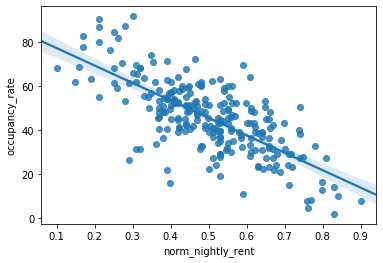

In [22]:
import seaborn as sns
ax = sns.regplot(x=df['norm_nightly_rent'], y=df['occupancy_rate'])

In [6]:
from scipy.optimize import minimize_scalar

optimal_rent= []

for i in df.index:
    def optimal_revenue(x):
        return -x*((0.1+0.8*((x-df.loc[i,'percentile_10th_price'])/(df.loc[i,'percentile_90th_price']-df.loc[i,'percentile_10th_price'])))*result.params[1]+result.params[0])/100*365
    
    res = minimize_scalar(optimal_revenue, method = 'bounded',bounds=(df.loc[i,'percentile_10th_price'],df.loc[i,'percentile_90th_price']))
    optimal_rent.append(res.x)

In [7]:
# Parameters
long_term_occupancy_rate = 36/37
fees = 0.3
capital_exp = 30000
years_depreciation = 5
fixed_replacement = 6000
utility = 300*12
avg_stay = 3
avg_nights_month = (365*3+366)/48
variable_hospitality_serveice = 100*avg_nights_month/avg_stay*12

In [9]:
df['optimal_rent'] = optimal_rent
df.to_csv('my_data_optimal_rent.csv')

In [20]:
# df['optimal_rent'] = optimal_rent
# df['norm_optimal_rent'] = 0.1+0.8*((df['optimal_rent']-df['percentile_10th_price'])/(df['percentile_90th_price']-df['percentile_10th_price']))
# df['predicted_occipancy_rate'] = df['norm_optimal_rent']*result.params[1]+result.params[0]
# df['st_optimal_revenue'] = df['optimal_rent']*df['predicted_occipancy_rate']/100*(avg_nights_month*12)
# df['st_optimal_revenue_after30fees'] = df['st_optimal_revenue']*(1-fees)
# df['lt_revenue'] = df['current_monthly_rent']*long_term_occupancy_rate*12

# cash_flow_cost_in_conversion_year = capital_exp+utility+(variable_hospitality_serveice*df['predicted_occipancy_rate']/100)
# cash_flow_cost_in_thereafter_year = fixed_replacement+utility+(variable_hospitality_serveice*df['predicted_occipancy_rate']/100)
# pl_cost_in_conversion_year = capital_exp/years_depreciation+utility+(variable_hospitality_serveice*df['predicted_occipancy_rate']/100)
# pl_cost_in_thereafter_year = capital_exp/years_depreciation+fixed_replacement+utility+(variable_hospitality_serveice*df['predicted_occipancy_rate']/100)

# df['cash_flow_chahge_in_conversion_year'] = (df['st_optimal_revenue_after30fees']-df['lt_revenue'])-cash_flow_cost_in_conversion_year
# df['cash_flow_chahge_in_thereafter_year'] = (df['st_optimal_revenue_after30fees']-df['lt_revenue'])-cash_flow_cost_in_thereafter_year

# df['pl_chahge_in_conversion_year'] = (df['st_optimal_revenue_after30fees']-df['lt_revenue'])-pl_cost_in_conversion_year
# df['pl_chahge_in_thereafter_year'] = (df['st_optimal_revenue_after30fees']-df['lt_revenue'])-pl_cost_in_thereafter_year

# df.head()